In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
seed_constant = 8
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# !unrar x UCF50.rar

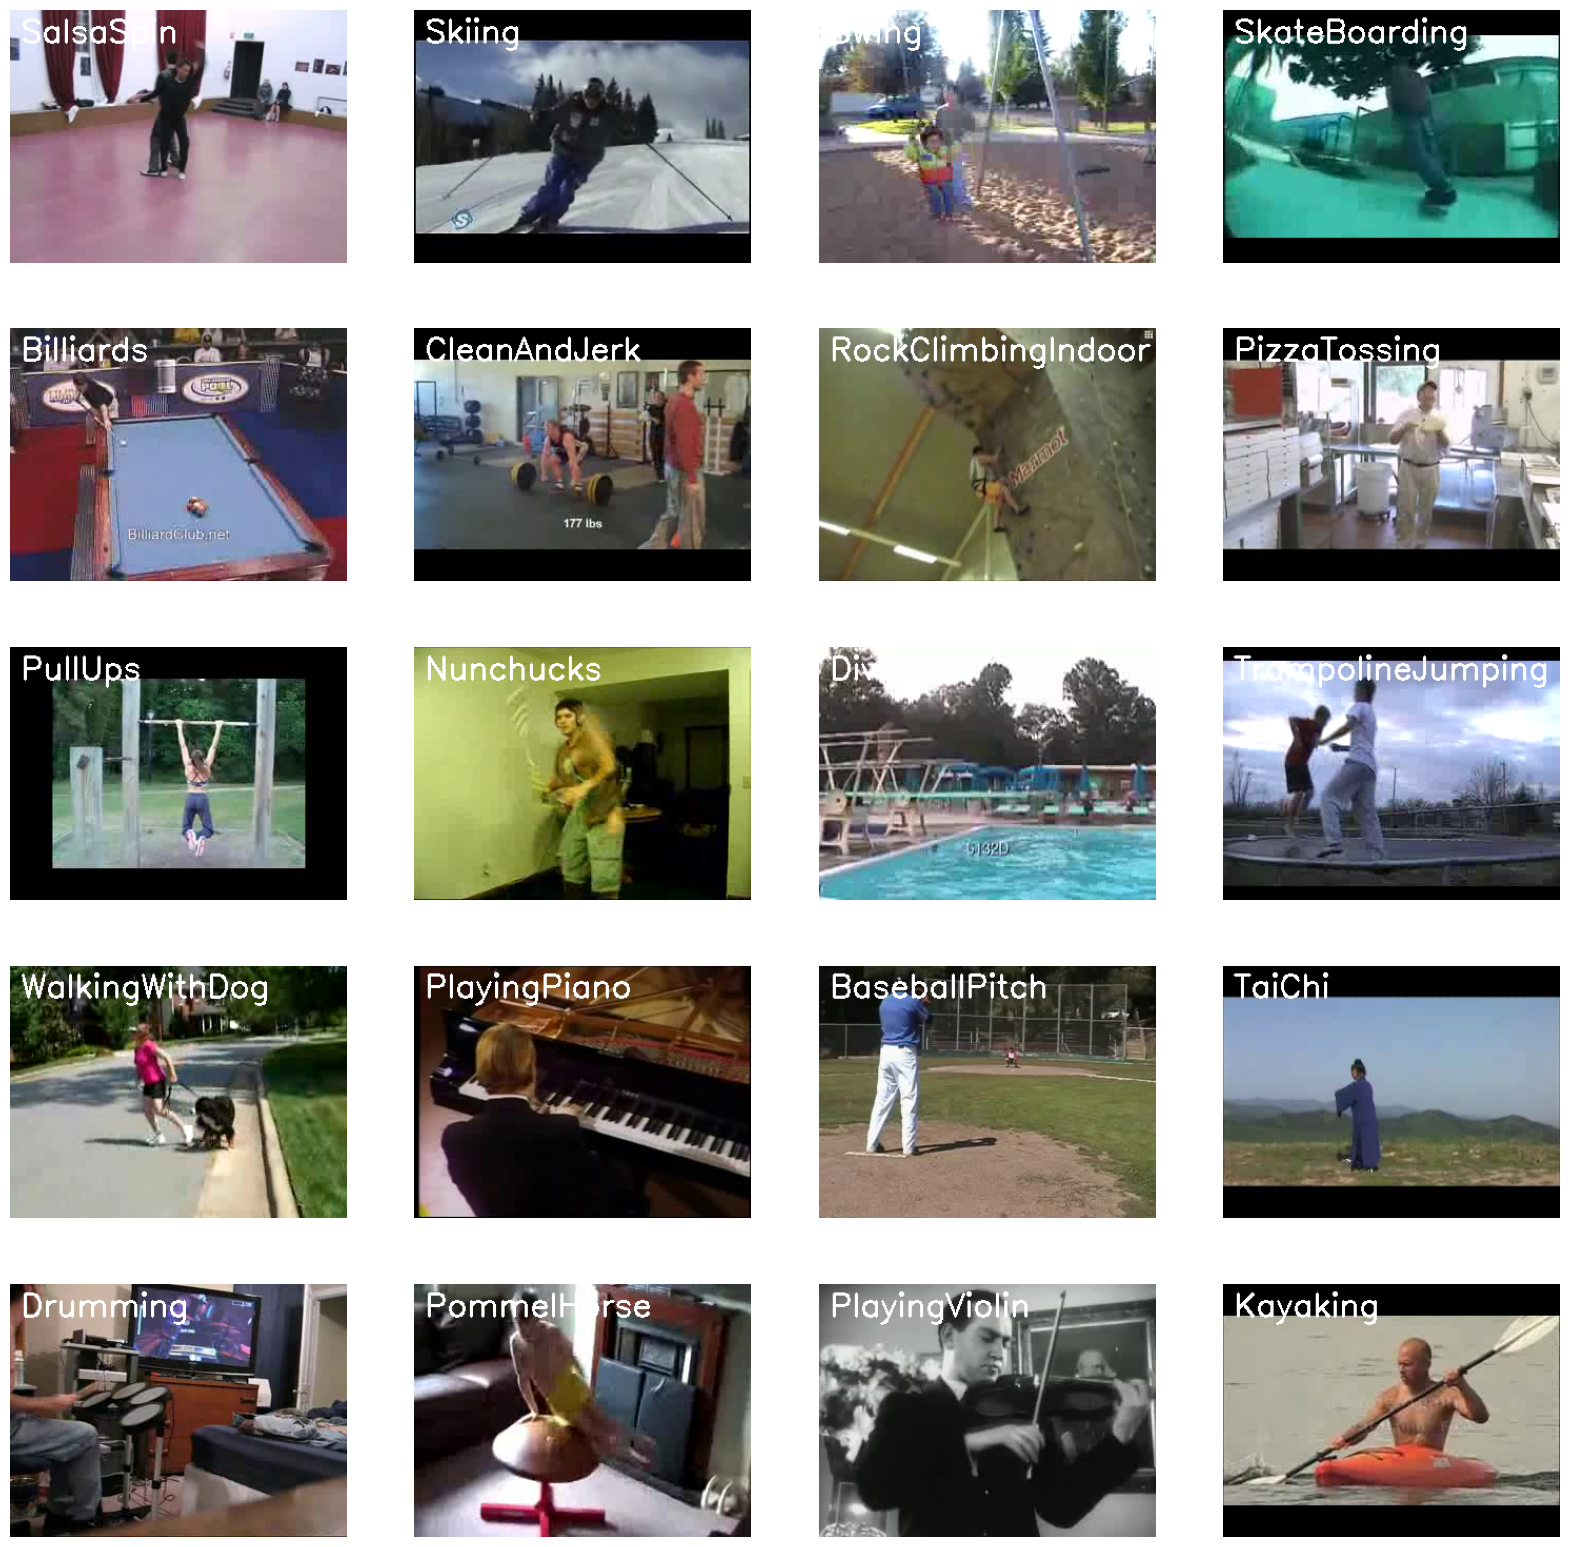

In [8]:
plt.figure(figsize=(20,20))

all_class_names = os.listdir('UCF50')
random_range = random.sample(range(len(all_class_names)), 20)

for counter, random_index in enumerate(random_range, 1):
  selected_class_name = all_class_names[random_index]
  video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')
  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')

  _, bgr_frame = video_reader.read()

  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  plt.subplot(5, 4, counter)
  plt.imshow(rgb_frame)
  plt.axis('off')

In [14]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [15]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame/255
    frames_list.append(normalized_frame)

  video_reader.release()
  return frames_list

In [18]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting data of class: {class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frames_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)


  features = np.asarray(features)
  labels = np.asarray(labels)

  return features, labels, video_files_paths

In [19]:
features, labels, video_files_paths = create_dataset()

Extracting data of class: WalkingWithDog
Extracting data of class: TaiChi
Extracting data of class: Swing
Extracting data of class: HorseRace


In [20]:
one_hot_encoded_labels = to_categorical(labels)

In [21]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)

In [ ]:
def create_convLSTM_model():
  model = Sequential()
  # define model architecture, i.e how many layers and its intricacies

  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8, kernel_size=(3,3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14, kernel_size=(3,3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16, kernel_size=(3,3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))

  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST), activation="softmax"))

  print(model.summary())

  return model

In [ ]:
plot_model(convLSTM, show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
convLSTM.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=['accuracy'])
convLSTM_history = convLSTM.fit(x=features_train, y=labels_train, epochs = 50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

In [ ]:
model_evaluation = convLSTM.evaluate(features_test, labels_test)

In [ ]:
def plot_metrics(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, "blue", label=metric_name_1)
  plt.plot(epochs, metric_value_2, "red", label=metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

In [ ]:
plot_metrics(convLSTM_history, 'loss', 'val_loss', "Total Loss v/s Total Validation Loss")

In [ ]:
plot_metrics(convLSTM_history, 'accuracy', 'val_accuracy', "Total Accuracu v/s Total Validation Accuracy")